In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline 
# magic command that allows the plots to be displayed directly in the Jupyter Notebook.
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score

pd.set_option('display.max_columns',500) 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ecommerce-transactions/Products.csv
/kaggle/input/ecommerce-transactions/Customers.csv
/kaggle/input/ecommerce-transactions/Transactions.csv


In [2]:
cust = pd.read_csv('/kaggle/input/ecommerce-transactions/Customers.csv')
trans = pd.read_csv('/kaggle/input/ecommerce-transactions/Transactions.csv')

df = pd.merge(cust, trans, on='CustomerID', how='inner')
df.head()

,CustomerID,CustomerName,Region,SignupDate,TransactionID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,C0001,Lawrence Carroll,South America,2022-07-10,T00015,P054,2024-01-19 03:12:55,2,114.60,57.30
1,C0001,Lawrence Carroll,South America,2022-07-10,T00932,P022,2024-09-17 09:01:18,3,412.62,137.54
2,C0001,Lawrence Carroll,South America,2022-07-10,T00085,P096,2024-04-08 00:01:00,2,614.94,307.47
3,C0001,Lawrence Carroll,South America,2022-07-10,T00445,P083,2024-05-07 03:11:44,2,911.44,455.72
4,C0001,Lawrence Carroll,South America,2022-07-10,T00436,P029,2024-11-02 17:04:16,3,1300.92,433.64


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerID       1000 non-null   object 
 1   CustomerName     1000 non-null   object 
 2   Region           1000 non-null   object 
 3   SignupDate       1000 non-null   object 
 4   TransactionID    1000 non-null   object 
 5   ProductID        1000 non-null   object 
 6   TransactionDate  1000 non-null   object 
 7   Quantity         1000 non-null   int64  
 8   TotalValue       1000 non-null   float64
 9   Price            1000 non-null   float64
dtypes: float64(2), int64(1), object(7)
memory usage: 78.2+ KB


In [4]:
df.describe()

,Quantity,TotalValue,Price
count,1000.000000,1000.000000,1000.00000
mean,2.537000,689.995560,272.55407
std,1.117981,493.144478,140.73639
min,1.000000,16.080000,16.08000
25%,2.000000,295.295000,147.95000
50%,3.000000,588.880000,299.93000
75%,4.000000,1011.660000,404.40000
max,4.000000,1991.040000,497.76000


In [5]:
order_value = df['TotalValue']
mean_value = order_value.mean()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


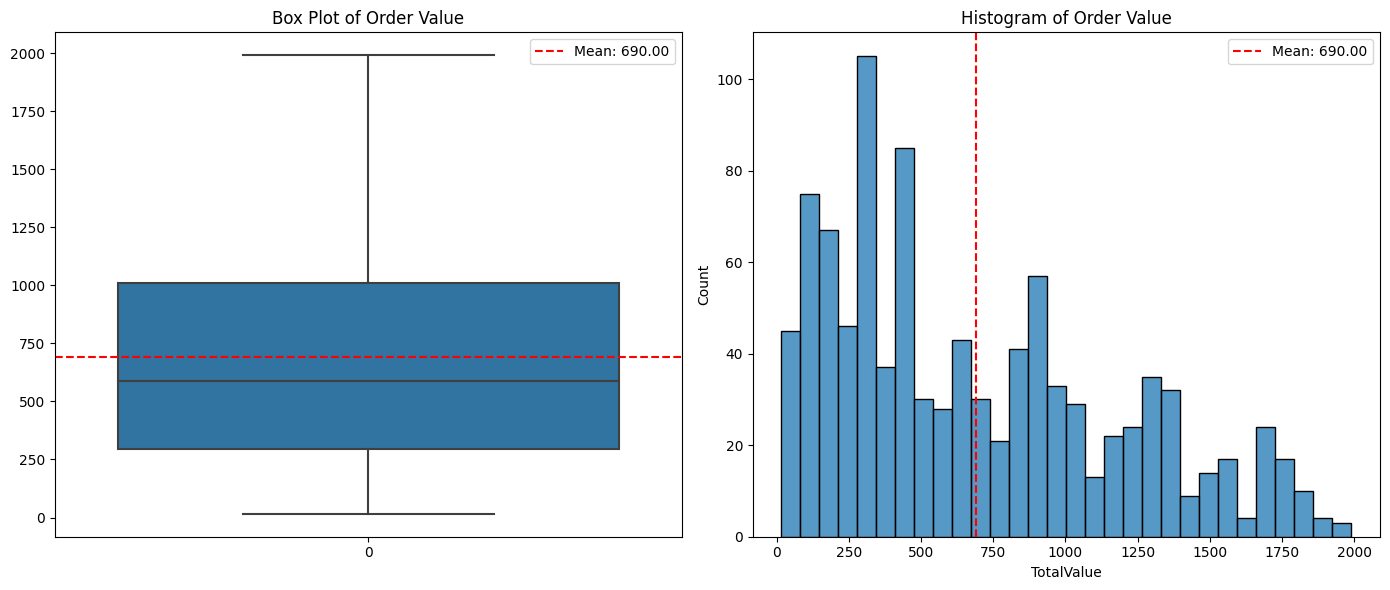

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(data=order_value, ax=axes[0])
axes[0].axhline(mean_value, color='r', linestyle='--', label=f'Mean: {mean_value:.2f}')
axes[0].set_title('Box Plot of Order Value')
axes[0].legend()

sns.histplot(order_value, bins=30, kde=False, ax=axes[1])
axes[1].axvline(mean_value, color='r', linestyle='--', label=f'Mean: {mean_value:.2f}')
axes[1].set_title('Histogram of Order Value')
axes[1].legend()

plt.tight_layout()
plt.show()

In [7]:
q1 = order_value.quantile(.25)
q3 = order_value.quantile(.75)

IQR = q3 - q1

print("Quartile Measurements for Annual Income")
print("1st Quartile: {} \n3rd Quartile: {} \nInter Quartile Range: {} \n".format(q1, q3, IQR))

limit = 1.5
upper_limit = q3 + (limit * IQR)
lower_limit = q1 - (limit * IQR)

print(f"Limits based on IQR Rule (Multiply IQR by {limit}, the constant used to detect outliers)")
print("Upper Limit: {} \nLower Limit: {} \n".format(upper_limit, lower_limit))

dataset = df.loc[(order_value <upper_limit) & (order_value > lower_limit)]
print('Total Outliers Removed: ',len(df)- len(dataset))

Quartile Measurements for Annual Income
1st Quartile: 295.29499999999996 
3rd Quartile: 1011.66 
Inter Quartile Range: 716.365 

Limits based on IQR Rule (Multiply IQR by 1.5, the constant used to detect outliers)
Upper Limit: 2086.2075 
Lower Limit: -779.2525000000002 

Total Outliers Removed:  0


In [8]:
df['CustomerID'] = df['CustomerID'].str.split('C0', expand=True)[1].astype('int')

In [9]:
clust_df = df.groupby(['CustomerID'])[['TotalValue', 'Quantity']].sum().reset_index()

In [10]:
clust_df['NumberOfTransactions'] = df['CustomerID'].map(df.groupby(['CustomerID'])['CustomerID'].count())
clust_df['AvgTransactionValue'] = clust_df['TotalValue'] / clust_df['NumberOfTransactions']

In [11]:
features = ['TotalValue', 'Quantity', 'NumberOfTransactions', 'AvgTransactionValue']

scaler = StandardScaler()
scaled_features = scaler.fit_transform(clust_df[features])

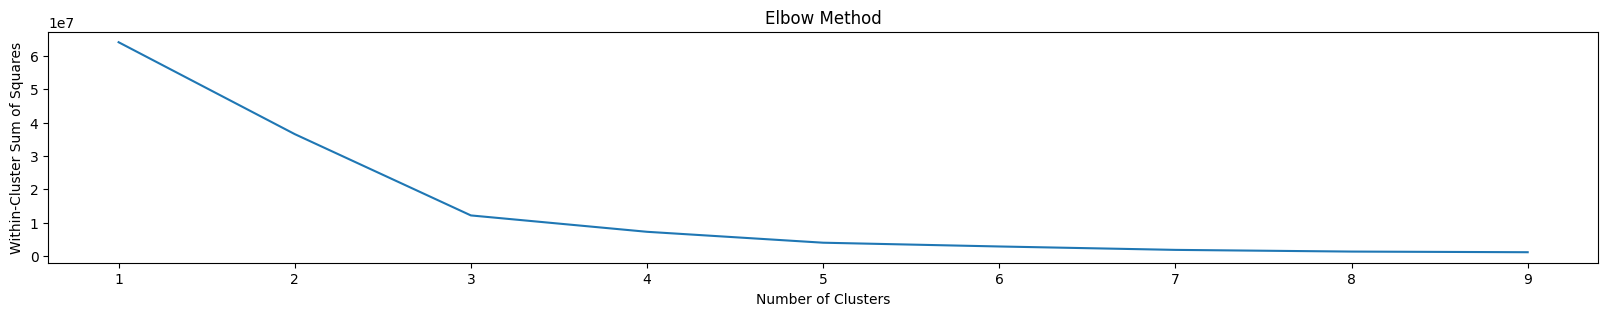

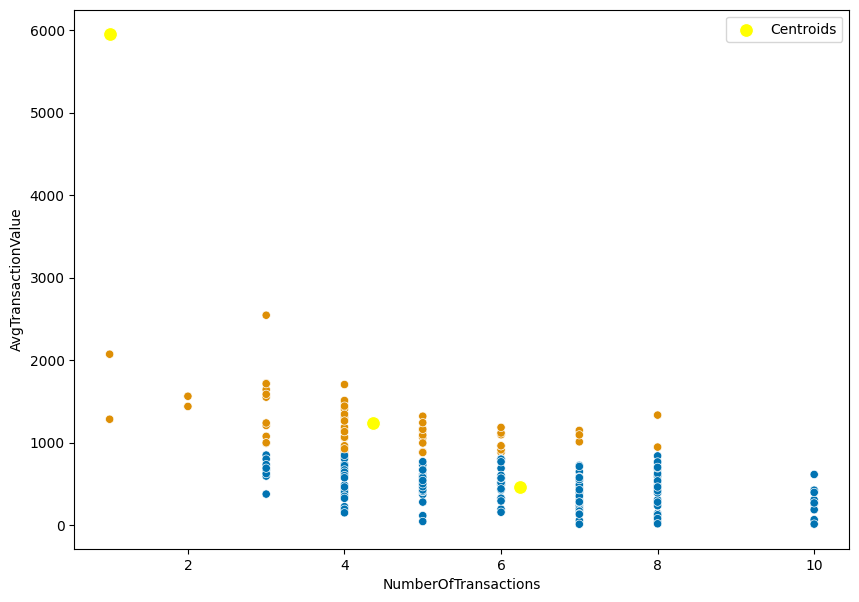

DB Index:  0.373927714209455


In [12]:
data = clust_df[['NumberOfTransactions', 'AvgTransactionValue']]
number_clusters=3
values = data.values
columns = data.columns

# Initialize an empty list to store the within-cluster sum of squares (inertia) values
inertias = []

# A range of n_clusters values to try
n_clusters_range = range(1, 10)

# Iterate over the cluster(1-10)
for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++'
                ,n_init='auto', max_iter=300, tol=0.0001, verbose=0
                ,random_state=None, copy_x=True, algorithm='lloyd')
    kmeans.fit(values)
    inertias.append(kmeans.inertia_)

# Plot the within-cluster sum of squares values
plt.figure(figsize=(20,3))
plt.plot(n_clusters_range, inertias)
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares')
plt.title('Elbow Method')
plt.show();

kmeans = KMeans(n_clusters=number_clusters, init='k-means++'
                ,n_init='auto', max_iter=300, tol=0.0001, verbose=0
                ,random_state=None, copy_x=True, algorithm='lloyd').fit(values)

plt.figure(figsize=(10,7))                
sns.scatterplot(data=clust_df, x=columns[0], y=columns[1], hue=kmeans.labels_, legend=False, palette='colorblind')
sns.scatterplot(x=kmeans.cluster_centers_[:,0], y=kmeans.cluster_centers_[:,1], color='Yellow', s=100, label='Centroids')
plt.xlabel(columns[0])
plt.ylabel(columns[1])
plt.show();
    
print("DB Index: ",davies_bouldin_score(data, kmeans.labels_))

In [13]:
# assign clustering to CustomerID
clust_df['Cluster'] = kmeans.fit_predict(scaled_features)
clust_df

,CustomerID,TotalValue,Quantity,NumberOfTransactions,AvgTransactionValue,Cluster
0,1,3354.52,12,5,670.904000,0
1,2,1862.74,10,5,372.548000,0
2,3,2725.38,14,5,545.076000,0
3,4,5354.88,23,5,1070.976000,2
4,5,2034.24,7,5,406.848000,0
...,...,...,...,...,...,...
194,196,4982.88,12,7,711.840000,1
195,197,1928.65,9,7,275.521429,1
196,198,931.83,3,7,133.118571,1
197,199,1979.28,9,7,282.754286,1


## Clustering Results Report

### 1. **Overview**
   In this report, The clustering results on customer data using the `AvgTransactionValue` and `NumberOfTransactions` features, The goal was to identify meaningful customer segments based on their spending behavior. Various clustering metrics, including the **Davies-Bouldin Index (DB Index)**, were calculated to evaluate the quality of the clusters formed.

### 2. **Number of Clusters Formed**
   Using the K-Means algorithm, we identified and optimized the number of clusters. Based on **Elbow Method**, the optimal number of clusters selected was:

   - **Number of clusters**: 3

   This number of clusters was found to be optimal as it balanced both intra-cluster compactness and inter-cluster separation.

### 3. **Clustering Metrics**

   #### a) **Davies-Bouldin Index (DB Index)**
   - **DB Index**: 0.37  
     The Davies-Bouldin Index measures the average similarity ratio of each cluster with the cluster most similar to it. A lower value of DB Index indicates that clusters are well-separated. In our case, a DB Index value of 0.37 suggests a reasonable separation between clusters.

### 4. **Summary of Clusters**
   The clustering algorithm grouped customers into 3 segments based on their spending behavior. Below is a summary of each cluster:

   - **Cluster 1**: This group contains customers with high total spend but fewer transactions. These customers likely make large, infrequent purchases.
   - **Cluster 2**: This group includes customers with low total spend but a higher transaction frequency, indicating regular but smaller purchases.
   - **Cluster 3**: Represents customers with moderate total spend and moderate transaction frequency, possibly an average customer group.

### 5. **Recommendations**
   Based on the clustering results:
   - **Cluster 1** (High spend, low frequency) could be targeted with high-value promotions or exclusive deals.
   - **Cluster 2** (Low spend, high frequency) could benefit from loyalty programs to encourage larger transactions.
   - **Cluster 3** (Moderate spend, moderate frequency) could be maintained with general promotional strategies to retain their consistent engagement.